In [1]:
!pip install -r requirements.txt --quiet

In [2]:
import os
import shutil

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pandas import DataFrame
from scipy.stats import mannwhitneyu, normaltest
from statannotations.Annotator import Annotator
from watermark import watermark

Download and unzip test data from our Zenodo repository

In [3]:
!pip install wget


In [4]:
import wget
wget.download('https://zenodo.org/record/7673199/files/Results_24h.zip?download=1')

100% [..........................................................................] 4943627 / 4943627

'Results_24h (1).zip'

In [5]:
!mkdir Results_test

A subdirectory or file Results_test already exists.


In [6]:
shutil.unpack_archive("Results_24h.zip", "Results_test/")

In [7]:
# @title
def visSets(set1: list, set2: list, csvpath: str) -> [DataFrame, DataFrame]:
    """
    Visualize sets of data from csv files in a given directory

    Parameters:
    set1 (list): List of strings indicating well names for set 1
    set2 (list): List of strings indicating well names for set 2
    csvpath (str): Path to directory containing csv files

    Returns:
    Tuple: A tuple of two pandas dataframes, containing data from well_set1 and well_set2 respectively

    """
    dir_list = os.listdir(csvpath)
    print("Files and directories in '", path, "' :")

    well_set1 = pd.DataFrame()
    well_set2 = pd.DataFrame()

    # read csv of set 1
    for well in set1:
        for csv in dir_list:
            if csv.find(well, 0, 3) > -1:
                csv_set = pd.read_csv(csvpath + csv, sep=",")
                csv_set["Well"] = well
                well_set1 = pd.concat([well_set1, csv_set])

    # read csv of set 2
    for well in set2:
        for csv in dir_list:
            if csv.find(well, 0, 3) > -1:
                csv_set = pd.read_csv(csvpath + csv, sep=",")
                csv_set["Well"] = well
                well_set2 = pd.concat([well_set2, csv_set])

    return well_set1, well_set2

In [8]:
# @title
def pltoSet1(B23: DataFrame):
    """
    This function creates a box plot using the Seaborn library. It takes a pandas DataFrame as input
    and visualizes the distribution of "Mean" values for different "Well" categories.
    The plot is created with a logarithmic x axis, horizontal boxes and grid lines for the x axis.
    The y axis is labeled with "Mean".

    Parameters:
    B23 (pd.DataFrame): A pandas DataFrame with columns "Well" and "Mean".

    Returns:
    None
    """
    sns.set_theme(style="ticks")

    # Initialize the figure
    f, ax = plt.subplots(figsize=(7, 6))

    # Plot
    sns.boxplot(
        x="Well",
        y="Mean",
        data=B23,
        width=0.6,
        palette="vlag",
        showfliers=False,
    )

    # Tweak the visual presentation
    ax.xaxis.grid(True)
    ax.set(ylabel="Mean")
    sns.despine(trim=True, left=True)

In [9]:
# @title
def norm_test(data: list, name: str):
    """
    Performs a normality test on a given data sample and returns a conclusion on whether the data is from a normal distribution.

    Inputs:
    data (list): A list of numerical values representing the data sample
    name (str): A string that represents the name of the data sample

    Outputs:
    None

    Side effects:
    Prints the p-value and the conclusion of the normality test on the data sample.

    Example:
    >>> norm_test([1, 2, 3, 4, 5], "Sample Data")
    p = 0.157298
    null hypothesis: Sample Data comes from a normal distribution
    The null hypothesis cannot be rejected
    """
    k2, p = normaltest(data)
    alpha = 1e-3
    print("p = {:g}".format(p))
    print("null hypothesis: {} comes from a normal distribution".format(name))
    if p < alpha:  # null hypothesis: Data from a normal distribution
        print("The null hypothesis can be rejected")
    else:
        print("The null hypothesis cannot be rejected")
    print("")

In [10]:
# @title
def visStats(set1: list, set2: list, path: str, stat_text: str, fig_name: str):
    """
    visStats(set1: list, set2: list, path: str, stat_text: str, fig_name: str):

    This function generates visualization of statistics between two sets of data and saves the figure to current path.

    set1: list
    A list of strings containing the name of each well in the first set.
    set2: list
    A list of strings containing the name of each well in the second set.
    path: str
    The path to the directory where the figure will be saved.
    stat_text: str
    The text to be added to the plot as a title or subtitle.
    fig_name: str
    The name of the figure file to be saved.

    Returns: None
    """

    well_set1, well_set2 = visSets(set1, set2, path)
    well_set1["Set"] = 1
    well_set1["Well"].describe()

    well_set2["Set"] = 2
    well_set2["Well"].describe()

    pltoSet1(well_set1)
    pltoSet1(well_set2)

    print("Statistics:")
    print("")

    csv_all = pd.concat([well_set1, well_set2])

    sns.set_theme(style="ticks")

    # Initialize the figure
    f, ax = plt.subplots(figsize=(7, 6))

    # Plot
    sns.boxplot(
        x="Well",
        y="Mean",
        data=csv_all,
        width=0.6,
        hue="Set",
        palette=["m", "g"],
    )

    # Tweak the visual presentation
    # ax.xaxis.grid(True)
    ax.set(ylabel="Mean")
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    # sns.despine(trim=True, left=True)

    for well in set1:
        norm_test(csv_all[csv_all["Well"] == well].Mean, well)

    for well in set2:
        norm_test(csv_all[csv_all["Well"] == well].Mean, well)

    # pvalues with scipy:
    stat_results = [
        mannwhitneyu(
            csv_all[csv_all["Well"] == set1[0]].Mean,
            csv_all[csv_all["Well"] == set2[0]].Mean,
            alternative="two-sided",
        ),
        mannwhitneyu(
            csv_all[csv_all["Well"] == set1[0]].Mean,
            csv_all[csv_all["Well"] == set2[1]].Mean,
            alternative="two-sided",
        ),
        mannwhitneyu(
            csv_all[csv_all["Well"] == set1[0]].Mean,
            csv_all[csv_all["Well"] == set2[2]].Mean,
            alternative="two-sided",
        ),
        mannwhitneyu(
            csv_all[csv_all["Well"] == set1[1]].Mean,
            csv_all[csv_all["Well"] == set2[0]].Mean,
            alternative="two-sided",
        ),
        mannwhitneyu(
            csv_all[csv_all["Well"] == set1[1]].Mean,
            csv_all[csv_all["Well"] == set2[1]].Mean,
            alternative="two-sided",
        ),
        mannwhitneyu(
            csv_all[csv_all["Well"] == set1[1]].Mean,
            csv_all[csv_all["Well"] == set2[2]].Mean,
            alternative="two-sided",
        ),
        mannwhitneyu(
            csv_all[csv_all["Well"] == set1[2]].Mean,
            csv_all[csv_all["Well"] == set2[0]].Mean,
            alternative="two-sided",
        ),
        mannwhitneyu(
            csv_all[csv_all["Well"] == set1[2]].Mean,
            csv_all[csv_all["Well"] == set2[1]].Mean,
            alternative="two-sided",
        ),
        mannwhitneyu(
            csv_all[csv_all["Well"] == set1[2]].Mean,
            csv_all[csv_all["Well"] == set2[2]].Mean,
            alternative="two-sided",
        ),
    ]

    pvalues = [result.pvalue for result in stat_results]
    print(pvalues)

    pairs = [
        (set1[0], set2[0]),
        (set1[0], set2[1]),
        (set1[0], set2[2]),
        (set1[1], set2[0]),
        (set1[1], set2[1]),
        (set1[1], set2[2]),
        (set1[2], set2[0]),
        (set1[2], set2[1]),
        (set1[2], set2[2]),
    ]

    formatted_pvalues = [f"p={p:.2e}" for p in pvalues]

    for p in pvalues:
        print(p)

    # prepare plots
    subcat_palette = sns.dark_palette("#8BF", reverse=True, n_colors=5)
    states_palette = sns.color_palette("YlGnBu", n_colors=5)

    cmap = sns.color_palette("colorblind")
    plotting_parameters = {
        "data": csv_all,
        "x": "Well",
        "y": "Mean",
        "showfliers": False,
        "width": 0.6,
        #'hue':"Set",
        "palette": [cmap[0], cmap[1], cmap[4], cmap[0], cmap[1], cmap[4]],
    }

    # show results
    with sns.plotting_context("notebook", font_scale=1.4):
        # Create new plot
        fig, ax = plt.subplots(1, 1, figsize=(12, 6))

        # Plot with seaborn
        sns.boxplot(**plotting_parameters)

        # Add annotations
        annotator = Annotator(ax, pairs, **plotting_parameters)
        ## p values
        # annotator.set_custom_annotations(formatted_pvalues)
        # annotator.annotate()

        ## <> p values
        annotator.configure(text_format="simple")
        annotator.set_pvalues(pvalues).annotate()

        # Label and show
        plt.title(stat_text, y=1.06)

        plt.savefig("./" + fig_name + ".png", bbox_inches="tight")
        plt.show()

In [11]:
# create an Empty DataFrame object
df = pd.DataFrame()

# append columns to an empty DataFrame
df["Set"] = []
df["Mean"] = []
df["Mean_25"] = []
df["Mean_75"] = []
df["Median"] = []
df["Median_25"] = []
df["Median_75"] = []
df["Area"] = []
df["Area_25"] = []
df["Area_75"] = []
df["MoA"] = []

print(df)

Empty DataFrame
Columns: [Set, Mean, Mean_25, Mean_75, Median, Median_25, Median_75, Area, Area_25, Area_75, MoA]
Index: []


# Data input setup

`path` to saved .csv files

In [12]:
path = "Results_test/Results_24h/"

list of .csv files:

In [13]:
dir_list = os.listdir(path)
print("Files and directories in '", path, "' :")
# prints all files
for file in dir_list:
    print(file)

Files and directories in ' Results_test/Results_24h/ ' :
B2_AllResults_2023-2-20_Results.csv
B3_AllResults_2023-2-20_Results.csv
B4_AllResults_2023-2-20_Results.csv
B6_AllResults_2023-2-20_Results.csv
B7_AllResults_2023-2-20_Results.csv
B8_AllResults_2023-2-20_Results.csv
C2_AllResults_2023-2-20_Results.csv
C3_AllResults_2023-2-20_Results.csv
C4_AllResults_2023-2-20_Results.csv
C6_AllResults_2023-2-20_Results.csv
C7_AllResults_2023-2-20_Results.csv
C8_AllResults_2023-2-20_Results.csv
D2_AllResults_2023-2-20_Results.csv
D3_AllResults_2023-2-20_Results.csv
D4_AllResults_2023-2-20_Results.csv
D6_AllResults_2023-2-20_Results.csv
D7_AllResults_2023-2-20_Results.csv
D8_AllResults_2023-2-20_Results.csv


Set up for controll, state wells and set name:

`vis_name` is tag for naming output images. They will be in form of *vis_name*_restOfImageName.

In [14]:
vis_name = "visTest"

In [15]:
set1c = ["B4", "C4", "D4"]  # kontrola
set1c_name = "CHOK1"

Set up for treatment, state wells and name for each set:

In [16]:
set2t = [
    ["B2", "C2", "D2"],  # 1
    ["B3", "C3", "D3"],  # 2
    ["B6", "C6", "D6"],  # 3
    ["B7", "C7", "D7"],  # 4
    ["B2", "C2", "D2"],  # 5
    ["B3", "C3", "D3"],  # 6
    ["B6", "C6", "D6"],  # 7
    ["B7", "C7", "D7"],  # 8
]

set2t_name = [
    "CHOK1 Val30",
    "CHOK1 Val15",
    "HeLa Val30",
    "HeLa Val15",
    "CHOK1 Val30",
    "CHOK1 Val15",
    "HeLa Val30",
    "HeLa Val15",
]
if len(set2t_name) == len(set2t):
    print("Set up complete")
else:
    print("Unequal set of wells and names")

Set up complete


## Proces data

0
Files and directories in ' Results_test/Results_24h/ ' :
Control
stats
Files and directories in ' Results_test/Results_24h/ ' :
Mean Brigthnes
Set1
1.5175330319658564
Set2
2.7853351628075256
Mean Area
Set1
2.185836373392589
Set2
0.8925180362722406
--Mean/Area--
Set1
0.6942573792065353
Set2
3.120760645287316
Fold: 4.495106193691487
Files and directories in ' Results_test/Results_24h/ ' :


C:\Users\mspat\AppData\Local\Temp\ipykernel_29776\223422558.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
C:\Users\mspat\AppData\Local\Temp\ipykernel_29776\223422558.py:106: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


Statistics:

p = 0
null hypothesis: B4 comes from a normal distribution
The null hypothesis can be rejected

p = 0
null hypothesis: C4 comes from a normal distribution
The null hypothesis can be rejected

p = 0
null hypothesis: D4 comes from a normal distribution
The null hypothesis can be rejected

p = 3.83985e-91
null hypothesis: B2 comes from a normal distribution
The null hypothesis can be rejected

p = 3.65029e-132
null hypothesis: C2 comes from a normal distribution
The null hypothesis can be rejected

p = 7.43303e-205
null hypothesis: D2 comes from a normal distribution
The null hypothesis can be rejected

[3.274811228713227e-05, 8.826891288114686e-06, 0.013499146565833932, 2.594999635228013e-07, 4.8776786587232774e-08, 0.0003006322299549634, 6.0793124768692265e-09, 7.176413438224875e-10, 1.0059298142048562e-05]
3.274811228713227e-05
8.826891288114686e-06
0.013499146565833932
2.594999635228013e-07
4.8776786587232774e-08
0.0003006322299549634
6.0793124768692265e-09
7.176413438224

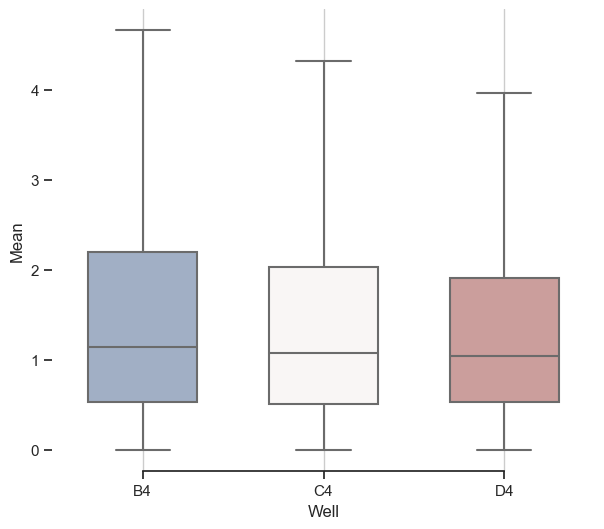

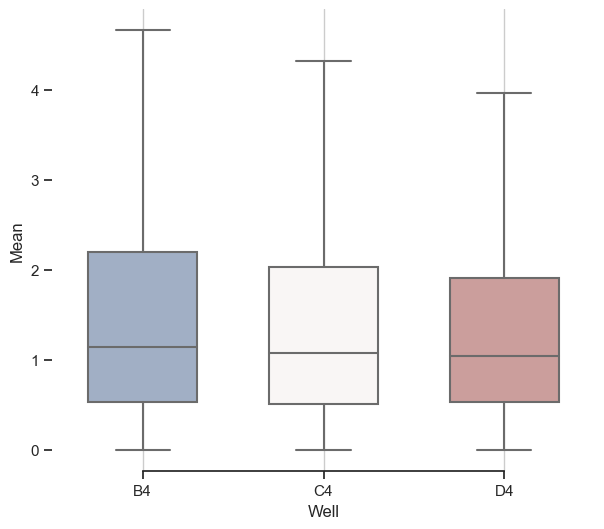

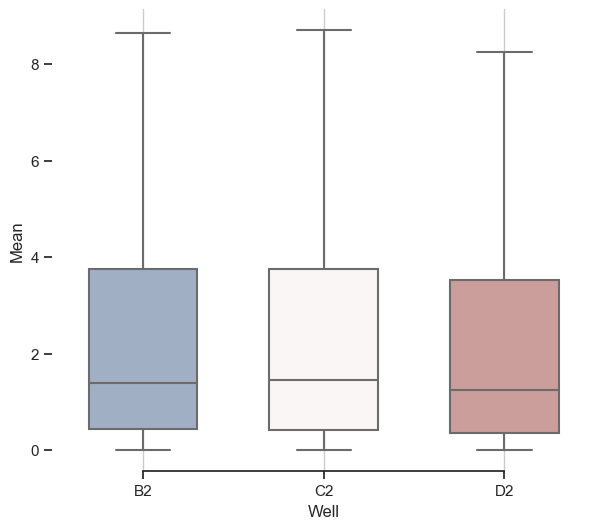

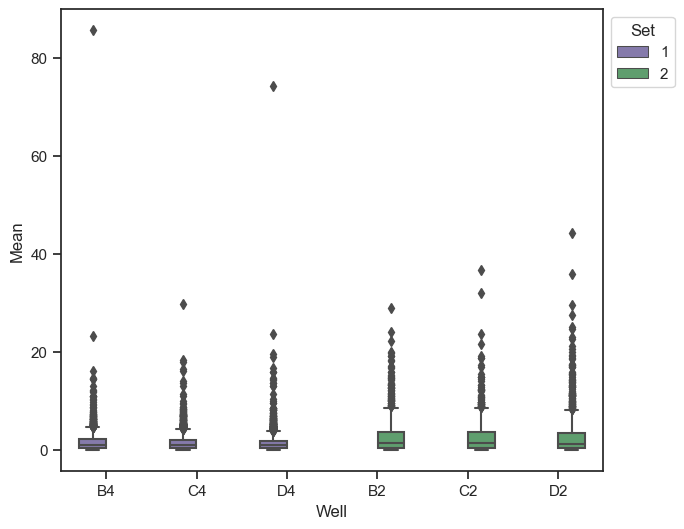

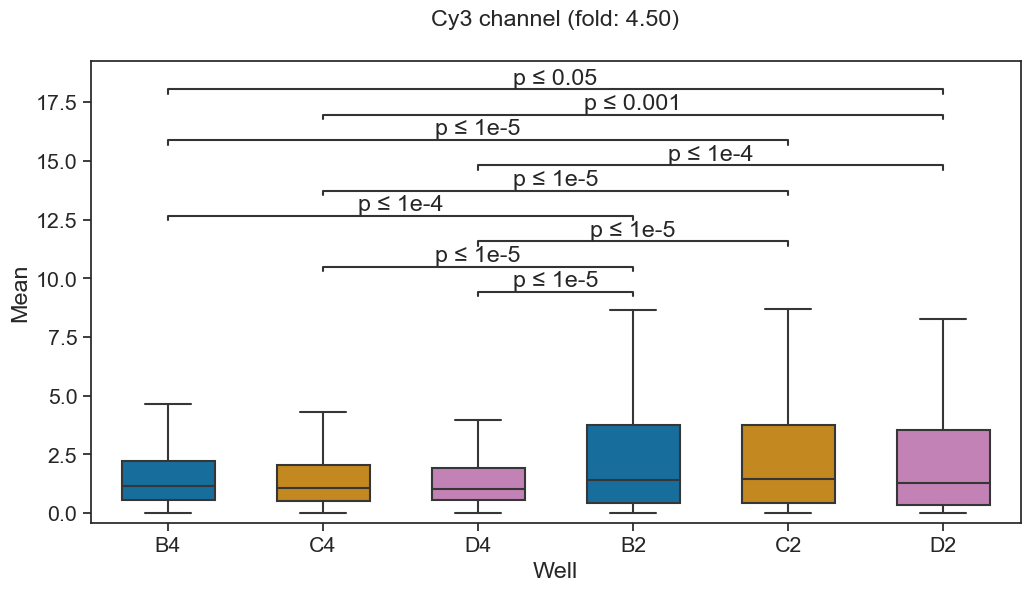

1
Files and directories in ' Results_test/Results_24h/ ' :
Control
stats
Files and directories in ' Results_test/Results_24h/ ' :
Mean Brigthnes
Set1
1.5175330319658564
Set2
2.604899894878706
Mean Area
Set1
2.185836373392589
Set2
1.1729507772313676


C:\Users\mspat\AppData\Local\Temp\ipykernel_29776\223422558.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
C:\Users\mspat\AppData\Local\Temp\ipykernel_29776\223422558.py:106: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


--Mean/Area--
Set1
0.6942573792065353
Set2
2.2208092150527494
Fold: 3.1988269503032227
Files and directories in ' Results_test/Results_24h/ ' :
Statistics:

p = 0
null hypothesis: B4 comes from a normal distribution
The null hypothesis can be rejected

p = 0
null hypothesis: C4 comes from a normal distribution
The null hypothesis can be rejected

p = 0
null hypothesis: D4 comes from a normal distribution
The null hypothesis can be rejected

p = 3.89979e-107
null hypothesis: B3 comes from a normal distribution
The null hypothesis can be rejected

p = 2.97402e-177
null hypothesis: C3 comes from a normal distribution
The null hypothesis can be rejected

p = 2.20308e-155
null hypothesis: D3 comes from a normal distribution
The null hypothesis can be rejected

[0.00011155128852390872, 4.2099442233497015e-25, 4.4523657751815e-16, 0.0018961526318700592, 1.6617302670803824e-22, 3.794852353738629e-14, 0.004980483144063663, 1.452003181301268e-21, 2.679328263860598e-13]
0.00011155128852390872
4.2

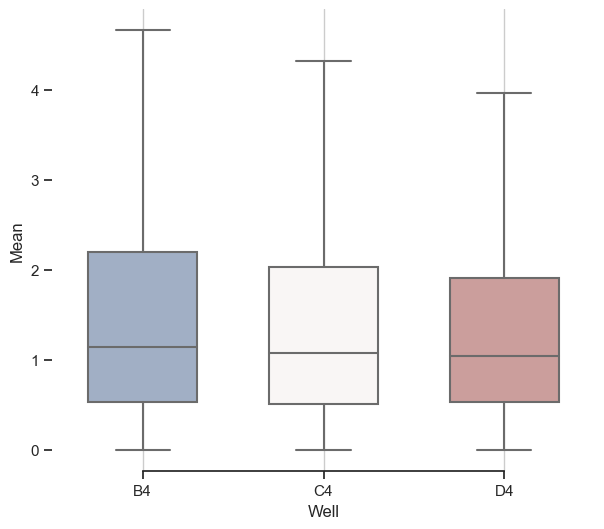

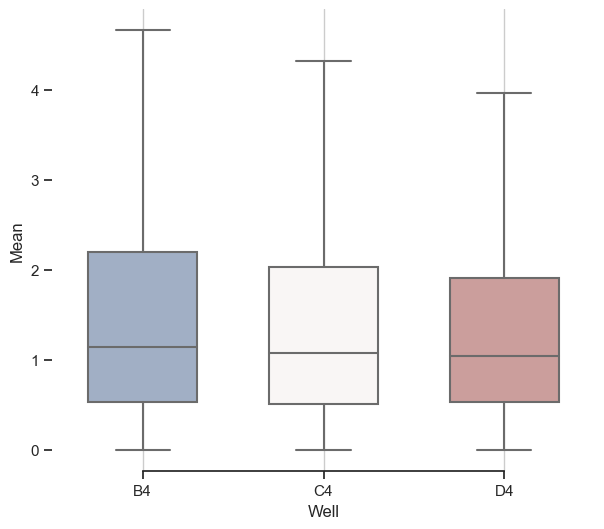

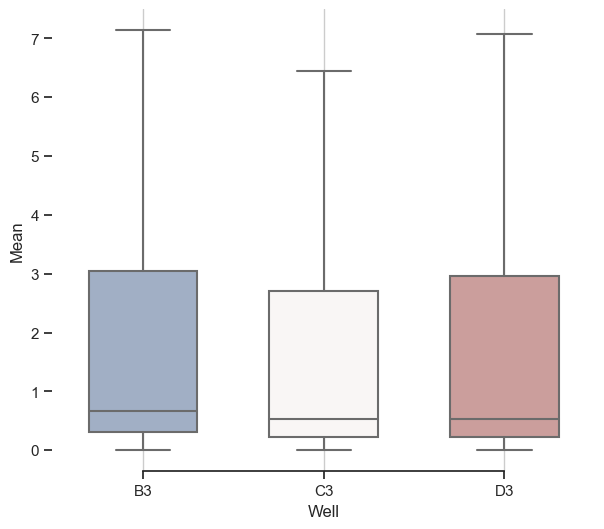

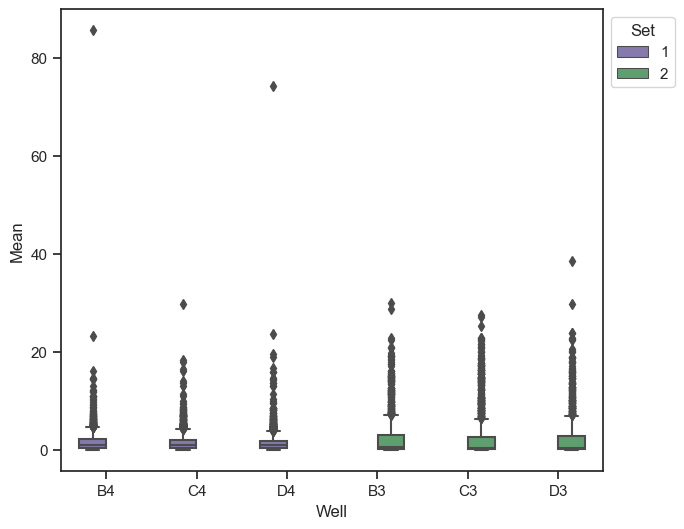

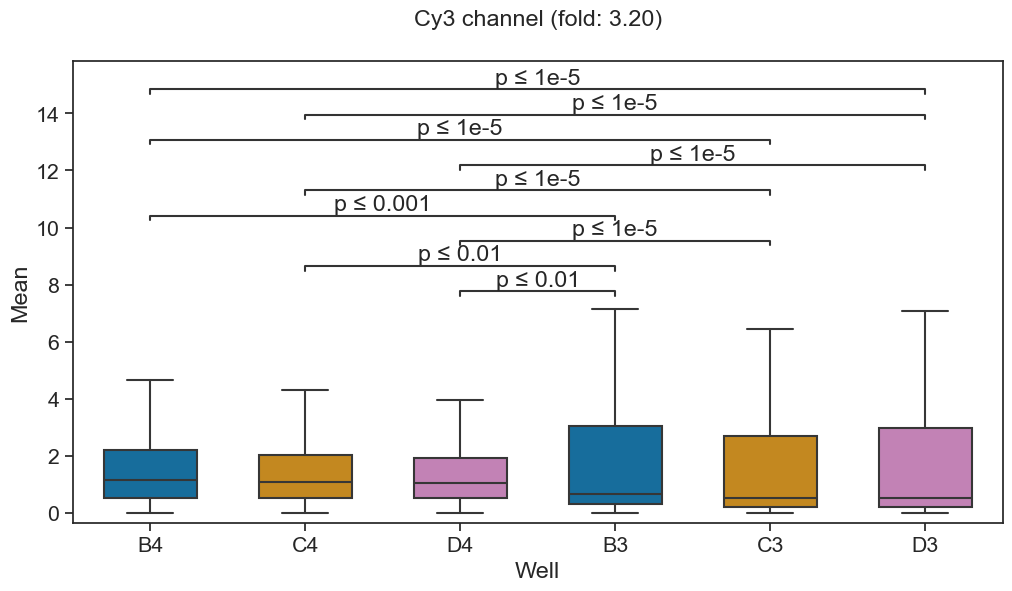

2
Files and directories in ' Results_test/Results_24h/ ' :
Control
stats
Files and directories in ' Results_test/Results_24h/ ' :
Mean Brigthnes
Set1
1.5175330319658564
Set2
0.5949237625231911
Mean Area
Set1
2.185836373392589
Set2
2.0698535539825422
--Mean/Area--
Set1
0.6942573792065353
Set2
0.28742311811312277
Fold: 0.4140008111136216
Files and directories in ' Results_test/Results_24h/ ' :


C:\Users\mspat\AppData\Local\Temp\ipykernel_29776\223422558.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
C:\Users\mspat\AppData\Local\Temp\ipykernel_29776\223422558.py:106: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


Statistics:

p = 0
null hypothesis: B4 comes from a normal distribution
The null hypothesis can be rejected

p = 0
null hypothesis: C4 comes from a normal distribution
The null hypothesis can be rejected

p = 0
null hypothesis: D4 comes from a normal distribution
The null hypothesis can be rejected

p = 0
null hypothesis: B6 comes from a normal distribution
The null hypothesis can be rejected

p = 0
null hypothesis: C6 comes from a normal distribution
The null hypothesis can be rejected

p = 0
null hypothesis: D6 comes from a normal distribution
The null hypothesis can be rejected

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
D4 vs. B6: Custom statistical test, P_val:0.000e+00
C4 vs. B6: Custom statistical test, P_val:0.000e+00
D4 vs. C6: Custom statistical test, P_val:0.000e+00
B4 vs. B6: Custom statistical test, P_val:0.000e+00
C4 vs. C6: Custom statistical test, P_val:0.000e+00
D4 vs. D6: Custom statistical test, P_val:0.000e+00
B4 vs. C6: Custom

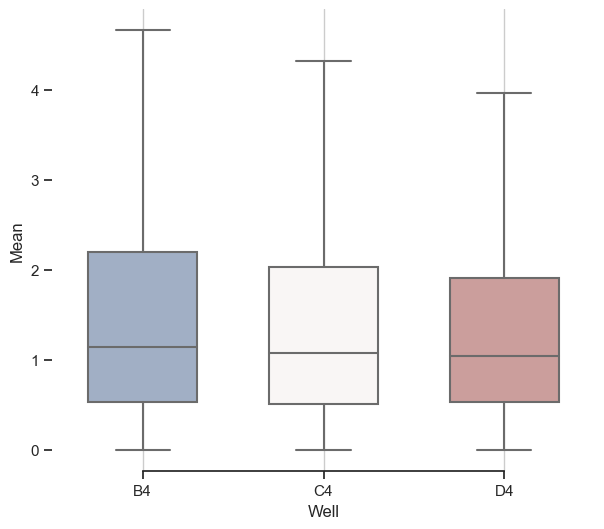

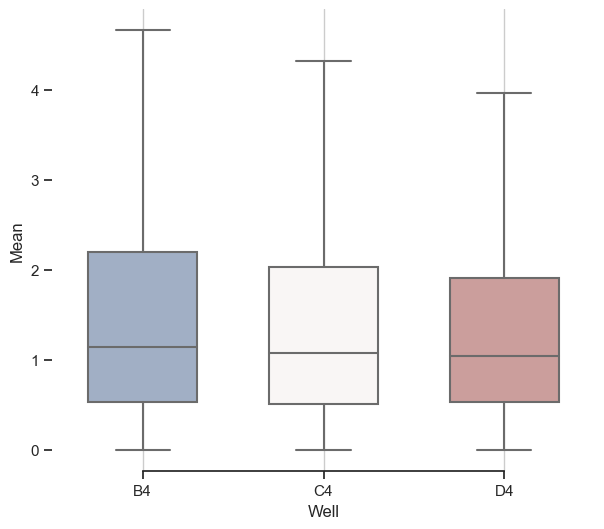

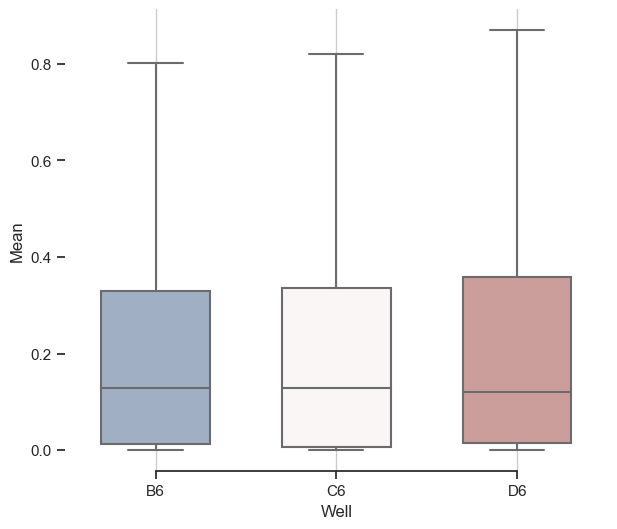

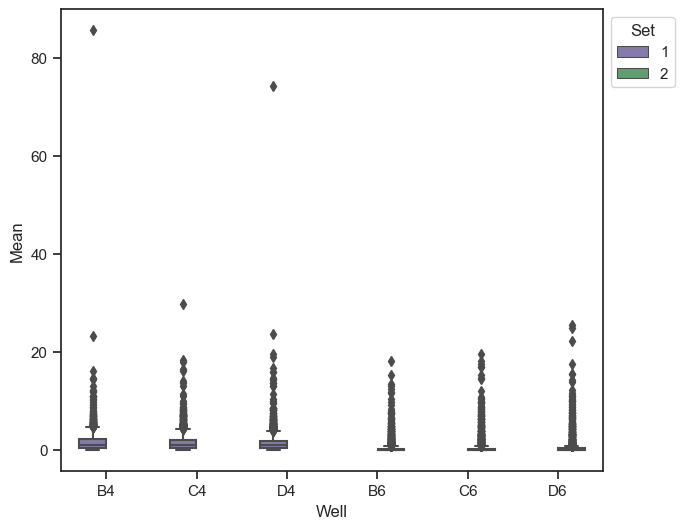

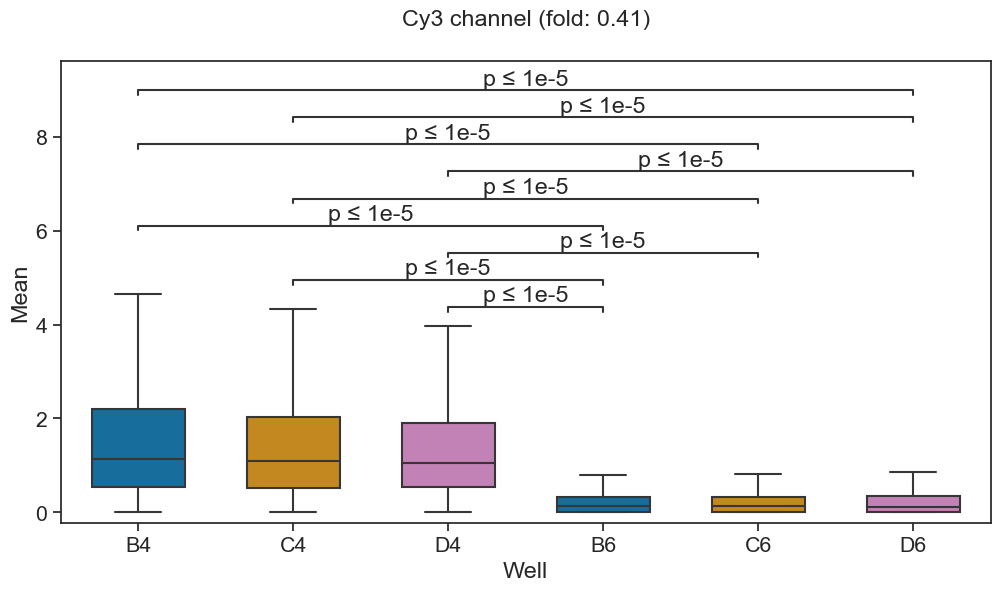

3
Files and directories in ' Results_test/Results_24h/ ' :
Control
stats
Files and directories in ' Results_test/Results_24h/ ' :
Mean Brigthnes
Set1
1.5175330319658564
Set2
0.35773621071486733
Mean Area
Set1
2.185836373392589
Set2
2.227306007159126


C:\Users\mspat\AppData\Local\Temp\ipykernel_29776\223422558.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
C:\Users\mspat\AppData\Local\Temp\ipykernel_29776\223422558.py:106: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


--Mean/Area--
Set1
0.6942573792065353
Set2
0.16061385798135167
Fold: 0.2313462741511178
Files and directories in ' Results_test/Results_24h/ ' :
Statistics:

p = 0
null hypothesis: B4 comes from a normal distribution
The null hypothesis can be rejected

p = 0
null hypothesis: C4 comes from a normal distribution
The null hypothesis can be rejected

p = 0
null hypothesis: D4 comes from a normal distribution
The null hypothesis can be rejected

p = 0
null hypothesis: B7 comes from a normal distribution
The null hypothesis can be rejected

p = 0
null hypothesis: C7 comes from a normal distribution
The null hypothesis can be rejected

p = 0
null hypothesis: D7 comes from a normal distribution
The null hypothesis can be rejected

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
D4 vs. B7: Custom statistical test, P_val:0.000e+00
C4 vs. B7: Custom statistical test, P_val:0.000e+00
D4 vs. C7: Custom statistical test, P_val:0.000e+00
B4 vs. B7: Custom statistica

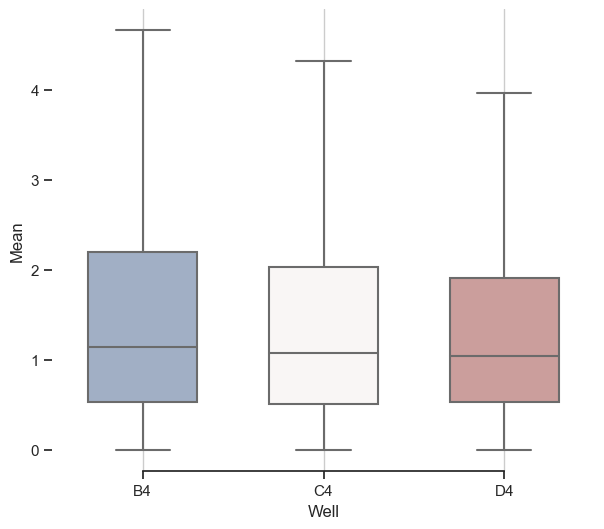

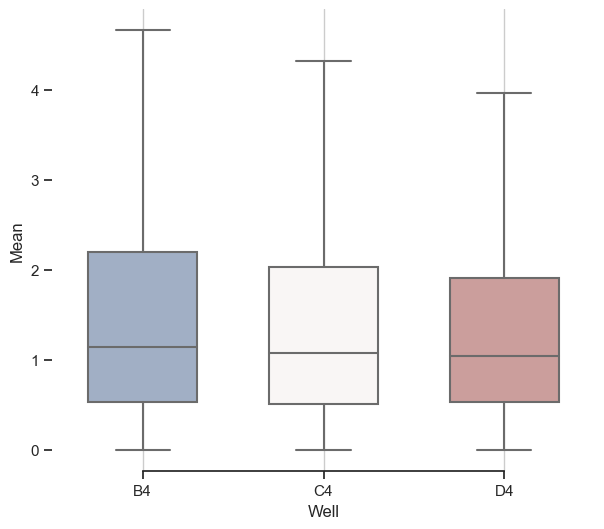

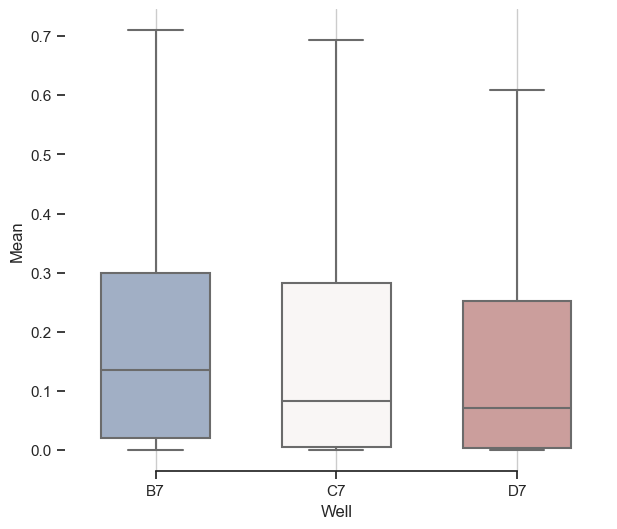

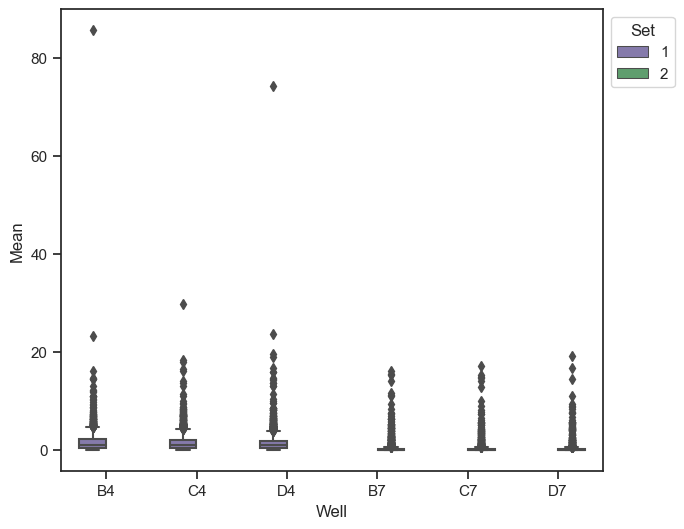

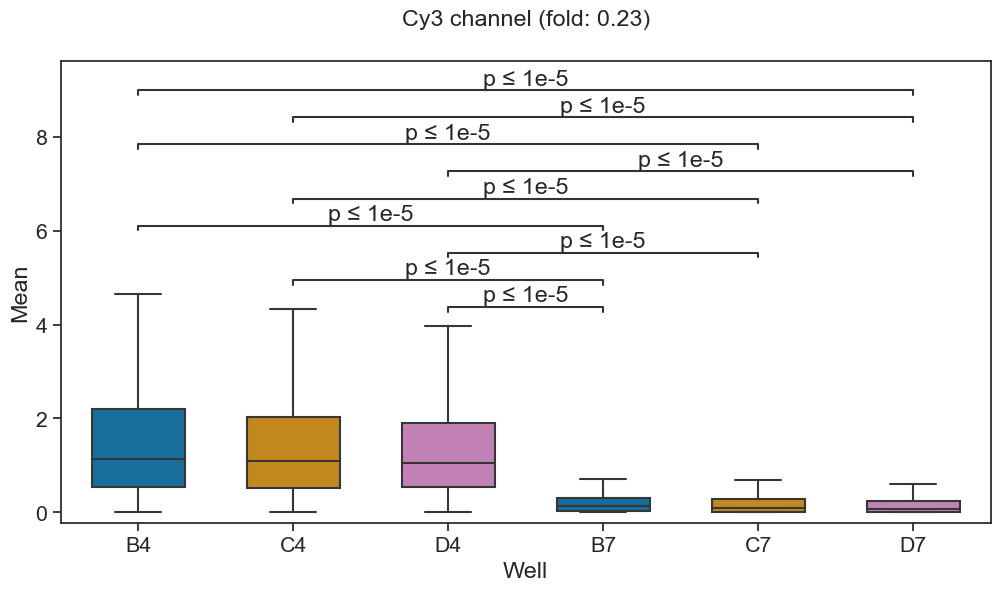

4
Files and directories in ' Results_test/Results_24h/ ' :
Control
stats
Files and directories in ' Results_test/Results_24h/ ' :
Mean Brigthnes
Set1
1.5175330319658564
Set2
2.7853351628075256
Mean Area
Set1
2.185836373392589
Set2
0.8925180362722406
--Mean/Area--
Set1
0.6942573792065353
Set2
3.120760645287316
Fold: 4.495106193691487
Files and directories in ' Results_test/Results_24h/ ' :


C:\Users\mspat\AppData\Local\Temp\ipykernel_29776\223422558.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
C:\Users\mspat\AppData\Local\Temp\ipykernel_29776\223422558.py:106: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


Statistics:

p = 0
null hypothesis: B4 comes from a normal distribution
The null hypothesis can be rejected

p = 0
null hypothesis: C4 comes from a normal distribution
The null hypothesis can be rejected

p = 0
null hypothesis: D4 comes from a normal distribution
The null hypothesis can be rejected

p = 3.83985e-91
null hypothesis: B2 comes from a normal distribution
The null hypothesis can be rejected

p = 3.65029e-132
null hypothesis: C2 comes from a normal distribution
The null hypothesis can be rejected

p = 7.43303e-205
null hypothesis: D2 comes from a normal distribution
The null hypothesis can be rejected

[3.274811228713227e-05, 8.826891288114686e-06, 0.013499146565833932, 2.594999635228013e-07, 4.8776786587232774e-08, 0.0003006322299549634, 6.0793124768692265e-09, 7.176413438224875e-10, 1.0059298142048562e-05]
3.274811228713227e-05
8.826891288114686e-06
0.013499146565833932
2.594999635228013e-07
4.8776786587232774e-08
0.0003006322299549634
6.0793124768692265e-09
7.176413438224

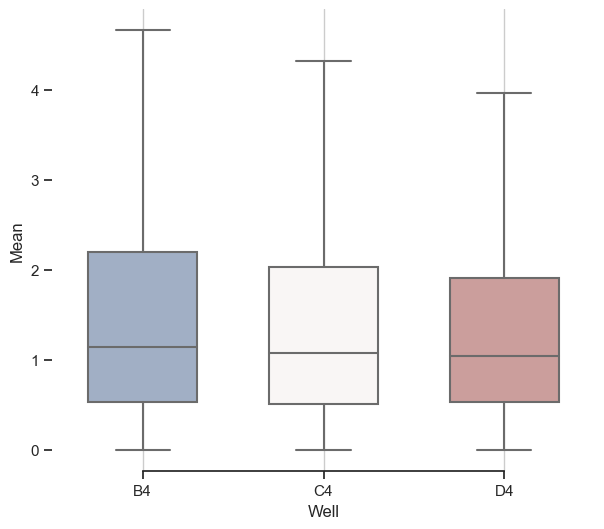

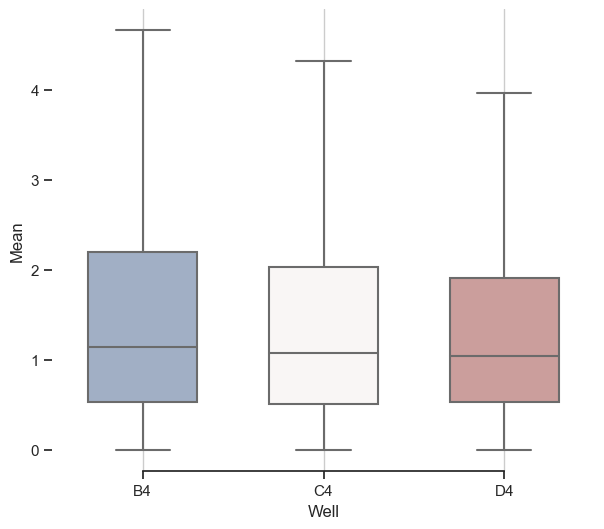

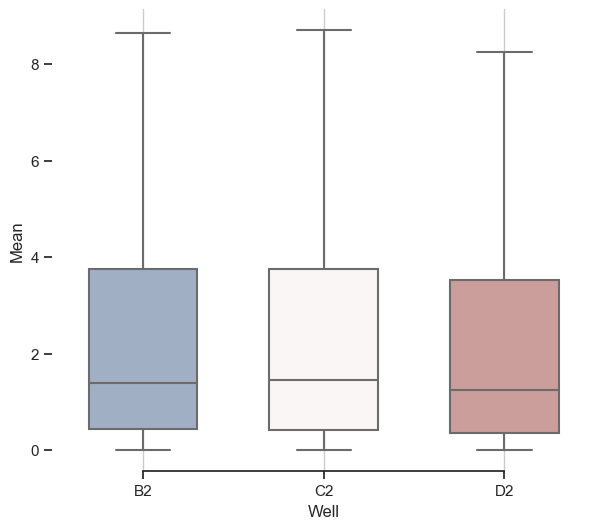

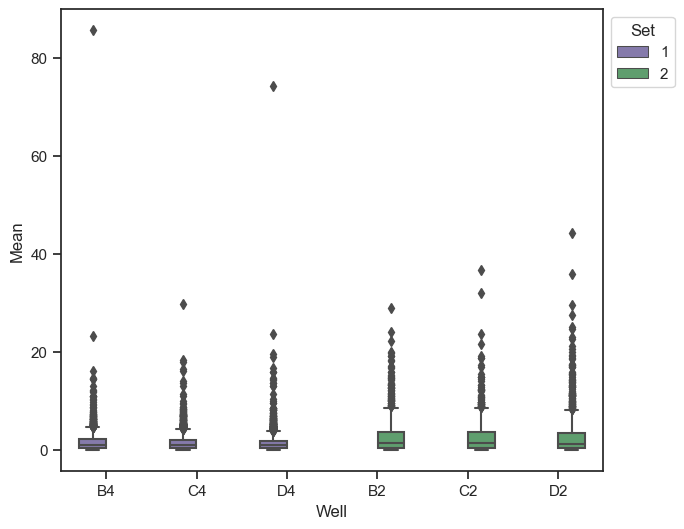

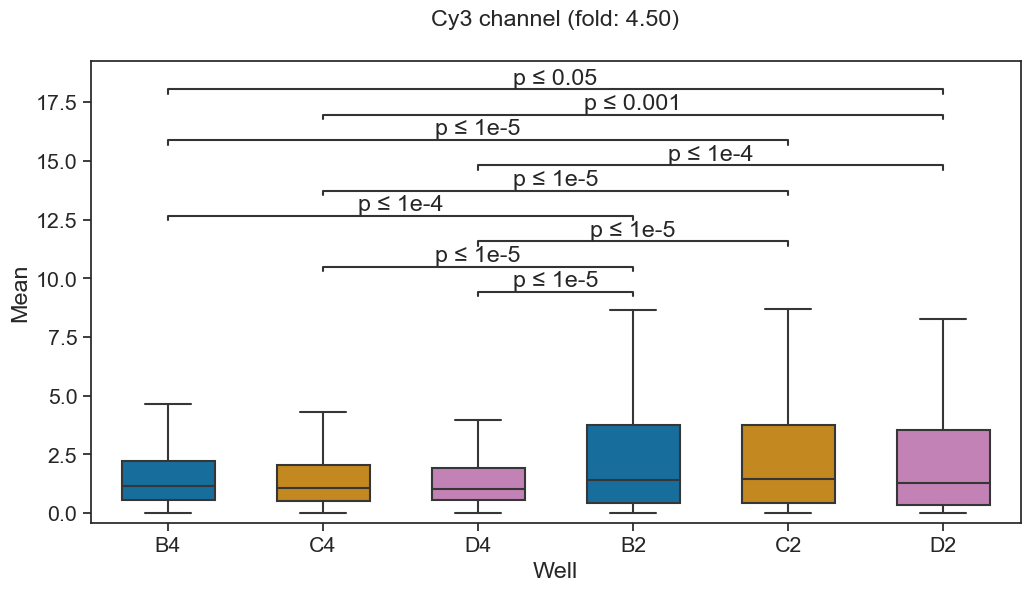

5
Files and directories in ' Results_test/Results_24h/ ' :
Control
stats
Files and directories in ' Results_test/Results_24h/ ' :
Mean Brigthnes
Set1
1.5175330319658564
Set2
2.604899894878706
Mean Area
Set1
2.185836373392589
Set2
1.1729507772313676
--Mean/Area--
Set1
0.6942573792065353
Set2
2.2208092150527494
Fold: 3.1988269503032227
Files and directories in ' Results_test/Results_24h/ ' :


C:\Users\mspat\AppData\Local\Temp\ipykernel_29776\223422558.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
C:\Users\mspat\AppData\Local\Temp\ipykernel_29776\223422558.py:106: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


Statistics:

p = 0
null hypothesis: B4 comes from a normal distribution
The null hypothesis can be rejected

p = 0
null hypothesis: C4 comes from a normal distribution
The null hypothesis can be rejected

p = 0
null hypothesis: D4 comes from a normal distribution
The null hypothesis can be rejected

p = 3.89979e-107
null hypothesis: B3 comes from a normal distribution
The null hypothesis can be rejected

p = 2.97402e-177
null hypothesis: C3 comes from a normal distribution
The null hypothesis can be rejected

p = 2.20308e-155
null hypothesis: D3 comes from a normal distribution
The null hypothesis can be rejected

[0.00011155128852390872, 4.2099442233497015e-25, 4.4523657751815e-16, 0.0018961526318700592, 1.6617302670803824e-22, 3.794852353738629e-14, 0.004980483144063663, 1.452003181301268e-21, 2.679328263860598e-13]
0.00011155128852390872
4.2099442233497015e-25
4.4523657751815e-16
0.0018961526318700592
1.6617302670803824e-22
3.794852353738629e-14
0.004980483144063663
1.45200318130126

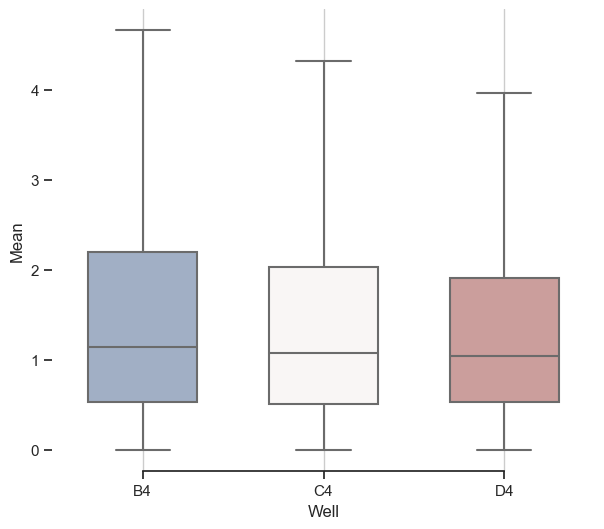

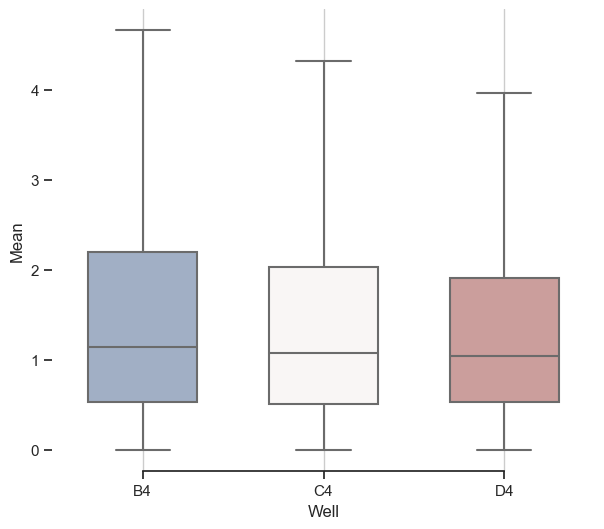

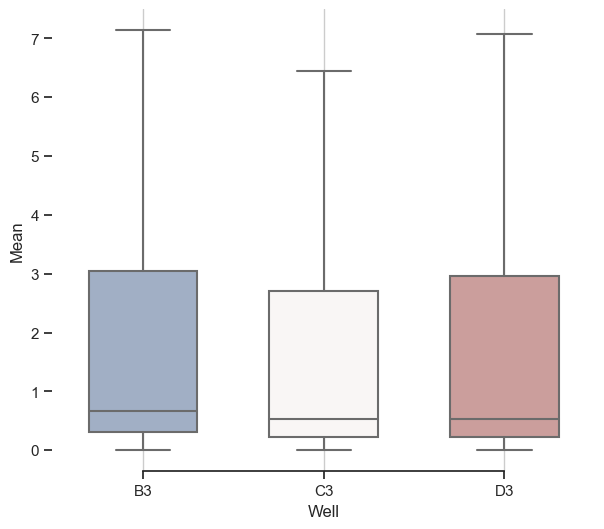

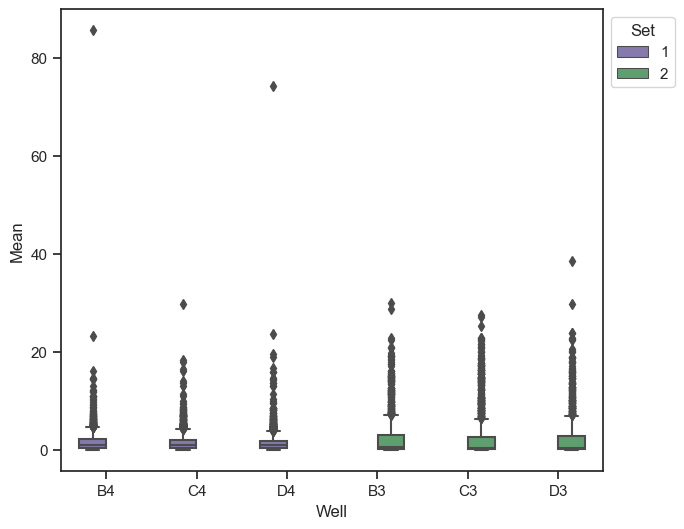

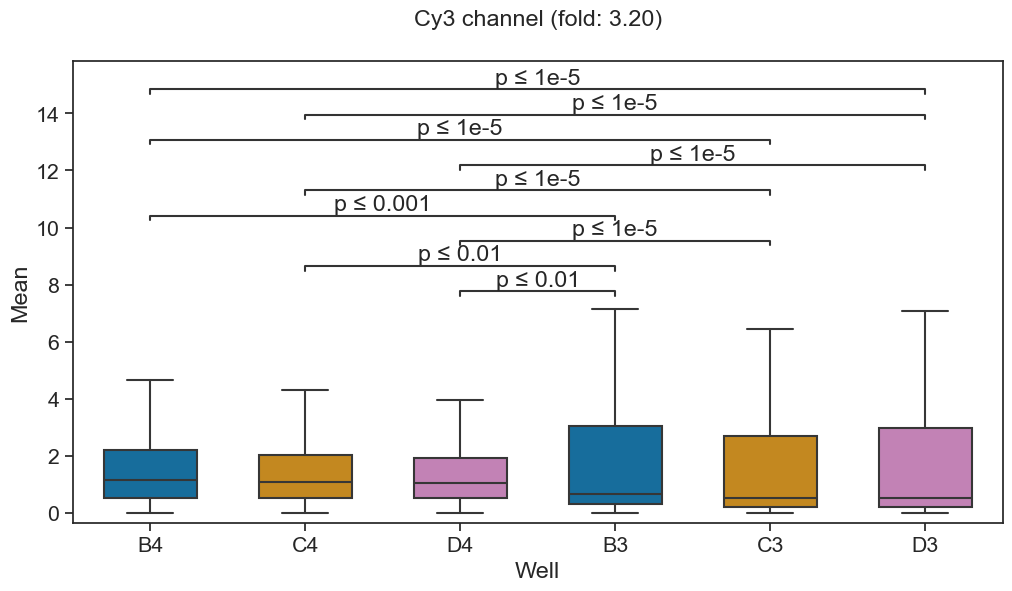

6
Files and directories in ' Results_test/Results_24h/ ' :
Control
stats
Files and directories in ' Results_test/Results_24h/ ' :
Mean Brigthnes
Set1
1.5175330319658564
Set2
0.5949237625231911
Mean Area
Set1
2.185836373392589
Set2
2.0698535539825422


C:\Users\mspat\AppData\Local\Temp\ipykernel_29776\223422558.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
C:\Users\mspat\AppData\Local\Temp\ipykernel_29776\223422558.py:106: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


--Mean/Area--
Set1
0.6942573792065353
Set2
0.28742311811312277
Fold: 0.4140008111136216
Files and directories in ' Results_test/Results_24h/ ' :
Statistics:

p = 0
null hypothesis: B4 comes from a normal distribution
The null hypothesis can be rejected

p = 0
null hypothesis: C4 comes from a normal distribution
The null hypothesis can be rejected

p = 0
null hypothesis: D4 comes from a normal distribution
The null hypothesis can be rejected

p = 0
null hypothesis: B6 comes from a normal distribution
The null hypothesis can be rejected

p = 0
null hypothesis: C6 comes from a normal distribution
The null hypothesis can be rejected

p = 0
null hypothesis: D6 comes from a normal distribution
The null hypothesis can be rejected

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
D4 vs. B6: Custom statistical test, P_val:0.000e+00
C4 vs. B6: Custom statistical test, P_val:0.000e+00
D4 vs. C6: Custom statistical test, P_val:0.000e+00
B4 vs. B6: Custom statistica

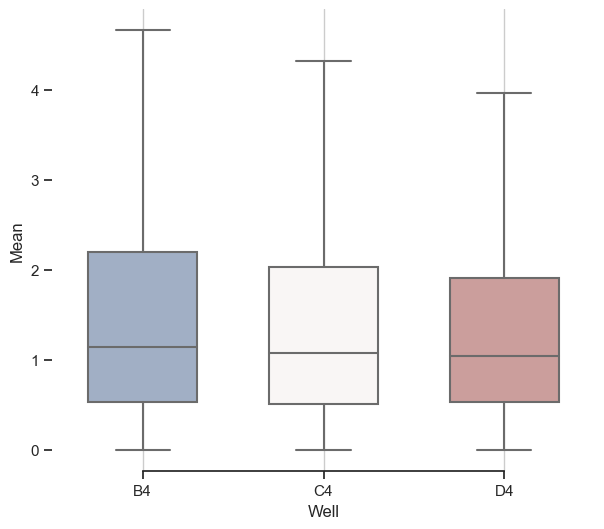

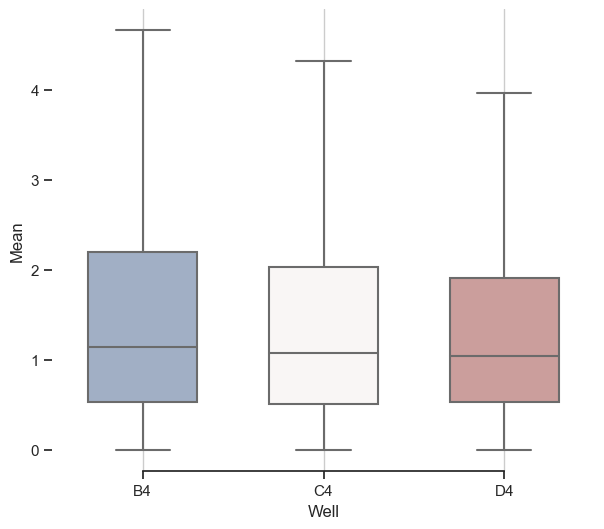

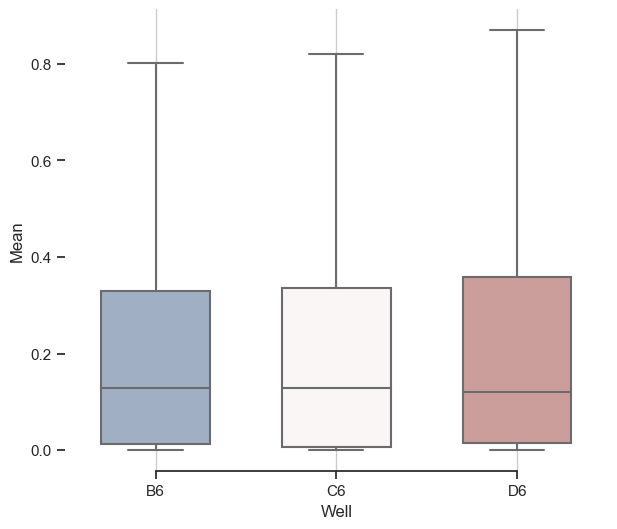

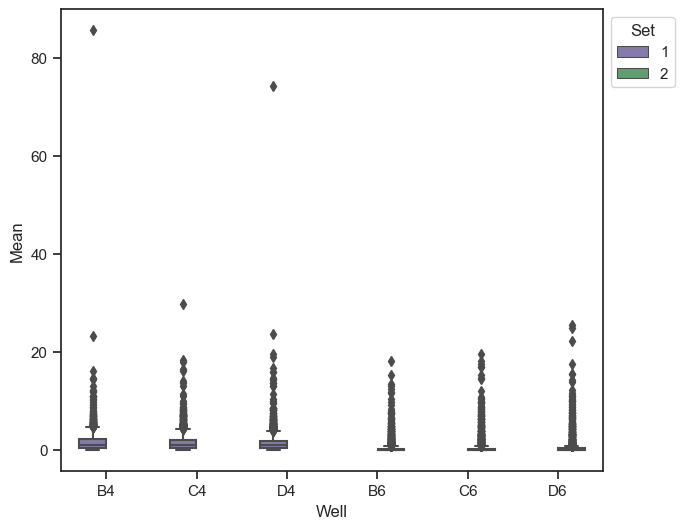

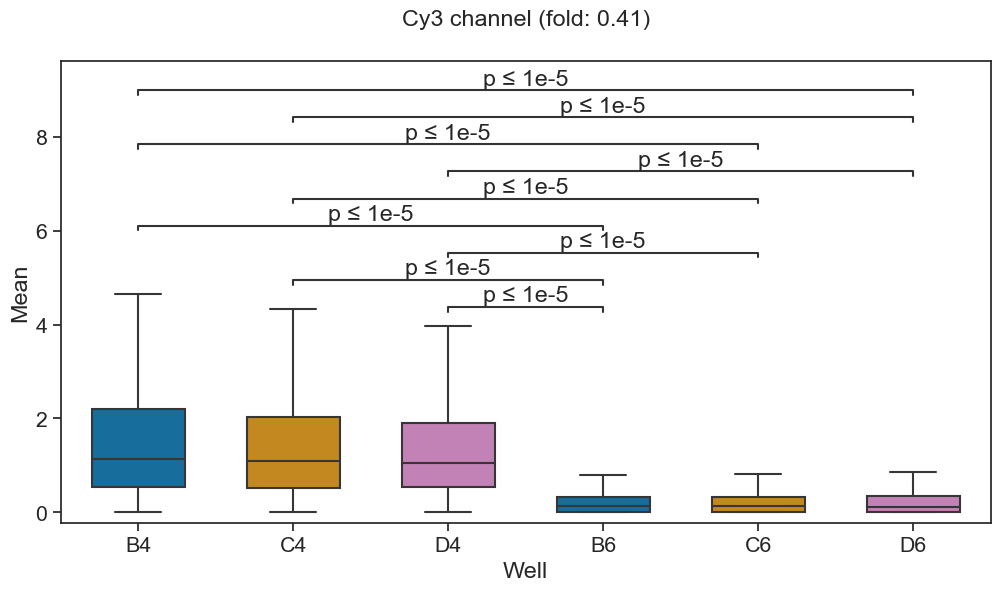

7
Files and directories in ' Results_test/Results_24h/ ' :
Control
stats
Files and directories in ' Results_test/Results_24h/ ' :
Mean Brigthnes
Set1
1.5175330319658564
Set2
0.35773621071486733
Mean Area
Set1
2.185836373392589
Set2
2.227306007159126


C:\Users\mspat\AppData\Local\Temp\ipykernel_29776\223422558.py:91: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
C:\Users\mspat\AppData\Local\Temp\ipykernel_29776\223422558.py:106: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


--Mean/Area--
Set1
0.6942573792065353
Set2
0.16061385798135167
Fold: 0.2313462741511178
Files and directories in ' Results_test/Results_24h/ ' :
Statistics:

p = 0
null hypothesis: B4 comes from a normal distribution
The null hypothesis can be rejected

p = 0
null hypothesis: C4 comes from a normal distribution
The null hypothesis can be rejected

p = 0
null hypothesis: D4 comes from a normal distribution
The null hypothesis can be rejected

p = 0
null hypothesis: B7 comes from a normal distribution
The null hypothesis can be rejected

p = 0
null hypothesis: C7 comes from a normal distribution
The null hypothesis can be rejected

p = 0
null hypothesis: D7 comes from a normal distribution
The null hypothesis can be rejected

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
D4 vs. B7: Custom statistical test, P_val:0.000e+00
C4 vs. B7: Custom statistical test, P_val:0.000e+00
D4 vs. C7: Custom statistical test, P_val:0.000e+00
B4 vs. B7: Custom statistica

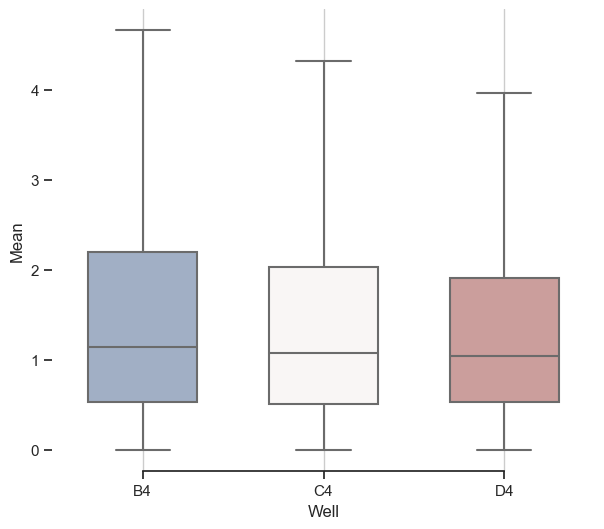

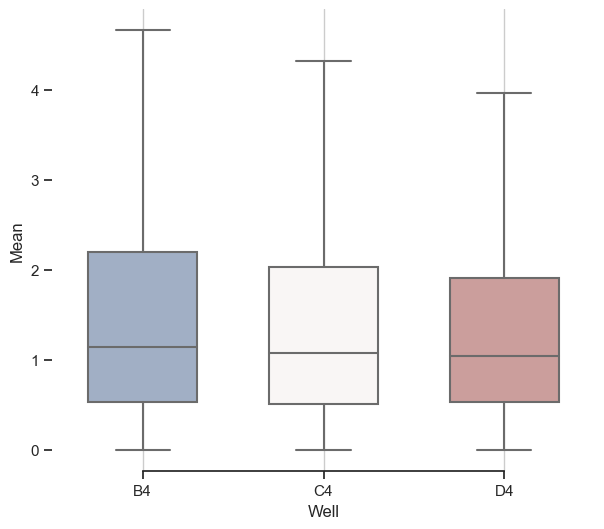

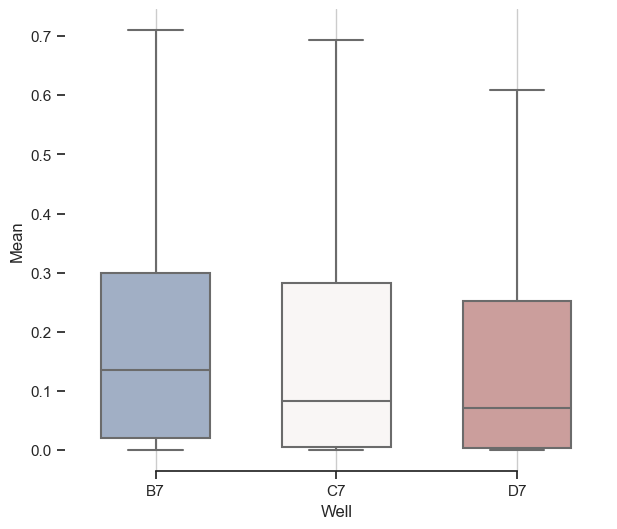

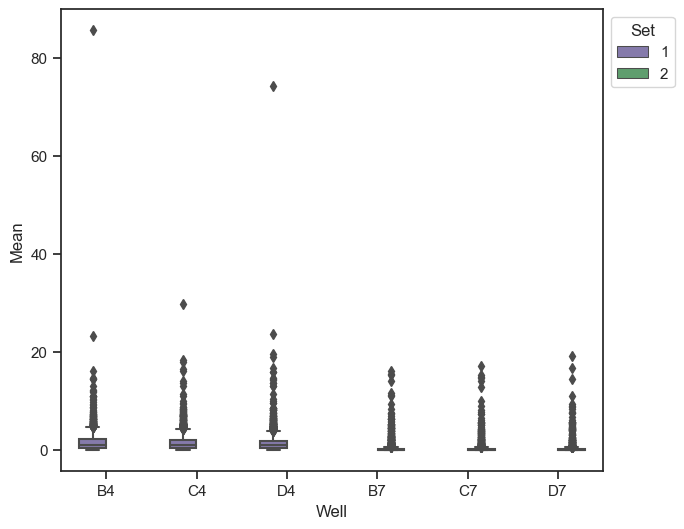

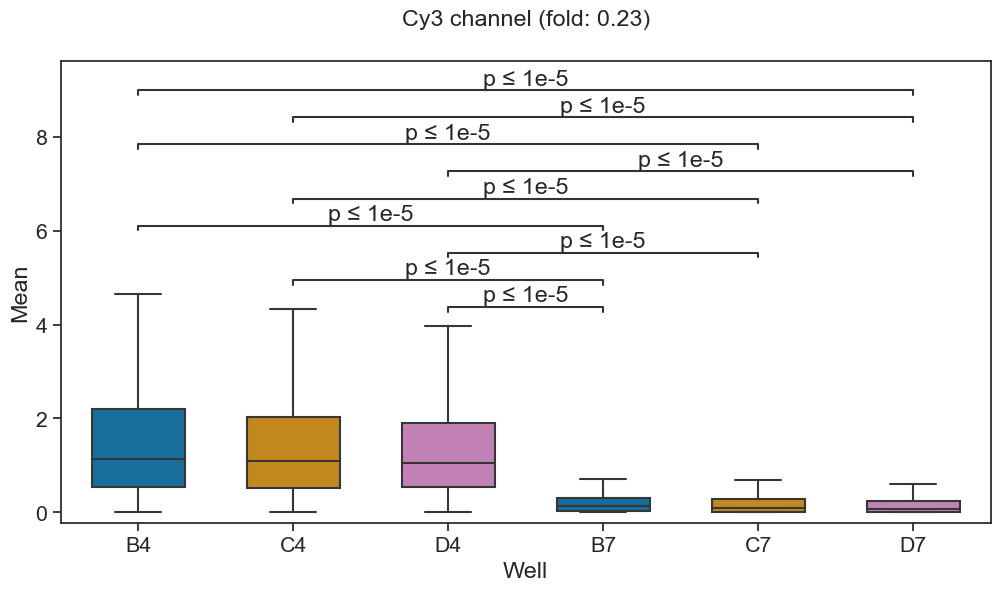

In [17]:
all_df = pd.DataFrame()
for s in range(len(set2t_name)):
    well_set1 = pd.DataFrame()
    well_set2 = pd.DataFrame()
    print(s)

    # get set of wells and names based on setup
    set1 = set1c
    set1_name = set1c_name
    set2 = set2t[s]
    set2_name = set2t_name[s]

    well_set1, well_set2 = visSets(set1, set2, path)
    well_set1["Set"] = 1
    well_set1["Set_name"] = set1_name
    well_set1.Mean.describe()

    well_set2["Set"] = 2
    well_set2["Set_name"] = set2_name
    well_set2.Mean.describe()

    ## load all data to all_df
    if s == 0:
        all_df = pd.concat([well_set1, well_set2])
    if s == 1:
        all_df = pd.concat([all_df, well_set2])
    if s == 2:
        all_df = pd.concat([all_df, well_set1, well_set2])
    if s == 3:
        all_df = pd.concat([all_df, well_set2])

    print("Control")
    sns.set_theme(style="ticks")

    # Initialize the figure
    f, ax = plt.subplots(figsize=(7, 6))

    # Plot
    sns.boxplot(
        x="Well",
        y="Mean",
        data=well_set1,
        width=0.6,
        palette="vlag",
        showfliers=False,
    )

    # Tweak the visual presentation
    ax.xaxis.grid(True)
    ax.set(ylabel="Mean")
    sns.despine(trim=True, left=True)

    print("stats")
    well_set1, well_set2 = visSets(set1, set2, path)

    ####!!!!correct worng pixel size, comment out if ours is correct in metadata!!!!
    well_set1["Area"] = (well_set1["Area"] / 0.0104167) * (0.65 * 0.65)
    well_set2["Area"] = (well_set2["Area"] / 0.0104167) * (0.65 * 0.65)

    well_set1["Set"] = 1
    well_set1["Well"].describe()

    well_set2["Set"] = 2
    well_set2["Well"].describe()

    print("Mean Brigthnes")
    print("Set1")
    print(well_set1["Mean"].mean())
    print("Set2")
    print(well_set2["Mean"].mean())

    print("Mean Area")
    print("Set1")
    print(well_set1["Area"].mean())
    print("Set2")
    print(well_set2["Area"].mean())

    new_row = {
        "Set": set1_name,
        "Mean": well_set1["Mean"].mean(),
        "Mean_25": well_set1["Mean"].quantile(q=0.25),
        "Mean_75": well_set1["Mean"].quantile(q=0.75),
        "Median": well_set1["Mean"].median(),
        "Median_25": well_set1["Mean"].quantile(q=0.25),
        "Median_75": well_set1["Mean"].quantile(q=0.75),
        "Area": well_set1["Area"].mean(),
        "Area_25": well_set1["Area"].quantile(q=0.25),
        "Area_75": well_set1["Area"].quantile(q=0.75),
        "MoA": well_set1["Mean"].mean() / well_set1["Area"].mean(),
    }
    df = df.append(new_row, ignore_index=True)
    # new_row = {'Set':"".join(set2), 'Mean':well_set2["Mean"].mean(), 'Median':well_set2["Area"].median(), 'Area':well_set2["Area"].mean(), 'MoA': well_set2["Mean"].mean()/well_set2["Area"].mean()}
    new_row = {
        "Set": set2_name,
        "Mean": well_set2["Mean"].mean(),
        "Mean_25": well_set2["Mean"].quantile(q=0.25),
        "Mean_75": well_set2["Mean"].quantile(q=0.75),
        "Median": well_set2["Mean"].median(),
        "Median_25": well_set2["Mean"].quantile(q=0.25),
        "Median_75": well_set2["Mean"].quantile(q=0.75),
        "Area": well_set2["Area"].mean(),
        "Area_25": well_set2["Area"].quantile(q=0.25),
        "Area_75": well_set2["Area"].quantile(q=0.75),
        "MoA": well_set2["Mean"].mean() / well_set2["Area"].mean(),
    }
    df = df.append(new_row, ignore_index=True)

    print("--Mean/Area--")
    print("Set1")
    m2a1 = well_set1["Mean"].mean() / well_set1["Area"].mean()
    print(m2a1)
    print("Set2")
    m2a2 = well_set2["Mean"].mean() / well_set2["Area"].mean()
    print(m2a2)

    print("Fold: {}".format(m2a2 / m2a1))

    visStats(
        set1,
        set2,
        path,
        "Cy3 channel (fold: {:.2f})".format(m2a2 / m2a1),
        vis_name + "_" + "".join(set1) + "".join(set2),
    )

## Output data table

In [18]:
df

,Set,Mean,Mean_25,Mean_75,Median,Median_25,Median_75,Area,Area_25,Area_75,MoA
0,CHOK1,1.517533,0.528740,2.038190,1.083710,0.528740,2.038190,2.185836,1.267496,2.240122,0.694257
1,CHOK1 Val30,2.785335,0.400345,3.629425,1.331940,0.400345,3.629425,0.892518,0.642468,1.047256,3.120761
2,CHOK1,1.517533,0.528740,2.038190,1.083710,0.528740,2.038190,2.185836,1.267496,2.240122,0.694257
3,CHOK1 Val15,2.604900,0.244392,2.914020,0.562035,0.244392,2.914020,1.172951,0.770232,1.342126,2.220809
4,CHOK1,1.517533,0.528740,2.038190,1.083710,0.528740,2.038190,2.185836,1.267496,2.240122,0.694257
5,HeLa Val30,0.594924,0.012050,0.335850,0.126520,0.012050,0.335850,2.069854,1.584269,2.389788,0.287423
6,CHOK1,1.517533,0.528740,2.038190,1.083710,0.528740,2.038190,2.185836,1.267496,2.240122,0.694257
7,HeLa Val15,0.357736,0.006680,0.281490,0.098750,0.006680,0.281490,2.227306,1.663766,2.556894,0.160614
8,CHOK1,1.517533,0.528740,2.038190,1.083710,0.528740,2.038190,2.185836,1.267496,2.240122,0.694257
9,CHOK1 Val30,2.785335,0.400345,3.629425,1.331940,0.400345,3.629425,0.892518,0.642468,1.047256,3.120761


## Results
The distributions of Mean Brightness from ROIs (MBR) do not have normal distribution (that can be partialy because the objects are close). So we should use MBR distribution median. In next table is MBR median, its Inter Quantile Range (IGR), and the same for MBR Mean. Area is in µm^2

In [29]:
df["Mean_IQR"] = df["Mean_75"] - df["Mean_25"]
df["Median_IQR"] = df["Median_75"] - df["Median_25"]
df["Area_IQR"] = df["Area_75"] - df["Area_25"]
df["MDoa"] = df["Median"] / df["Area"]
df.rename(columns={"Mean": "MFV"}, inplace=True)
df.rename(columns={"Mean_IQR": "MFV_IQR"}, inplace=True)
df2=df[
    [
        "Set",
        "MFV",
        "MFV_IQR",
        # "Median",
        # "Median_IQR",
        "Area",
        "Area_IQR",
        "MoA",
        # "MDoa",
    ]
]
df2

,Set,MFV,MFV_IQR,MFV_IQR,Area,Area_IQR,MoA
0,CHOK1,1.517533,1.509450,1.509450,2.185836,0.972626,0.694257
1,CHOK1 Val30,2.785335,3.229080,3.229080,0.892518,0.404788,3.120761
2,CHOK1,1.517533,1.509450,1.509450,2.185836,0.972626,0.694257
3,CHOK1 Val15,2.604900,2.669627,2.669627,1.172951,0.571894,2.220809
4,CHOK1,1.517533,1.509450,1.509450,2.185836,0.972626,0.694257
5,HeLa Val30,0.594924,0.323800,0.323800,2.069854,0.805519,0.287423
6,CHOK1,1.517533,1.509450,1.509450,2.185836,0.972626,0.694257
7,HeLa Val15,0.357736,0.274810,0.274810,2.227306,0.893128,0.160614
8,CHOK1,1.517533,1.509450,1.509450,2.185836,0.972626,0.694257
9,CHOK1 Val30,2.785335,3.229080,3.229080,0.892518,0.404788,3.120761


### Renaming of Columns

In [31]:
newSet="newSet"
newMFV="newMFV"
newMFV_IQR="newMFV_IQR"
newArea="newArea"
newArea_IQR="newArea_IQR"
newMoA="newMoA"


df2.rename(columns={"Set": newSet, "MFV": newMFV, "MFV_IQR": newMFV_IQR, "Area": newArea, "Area_IQR": newArea_IQR, "MoA": newMoA})

,newSet,newMFV,newMFV_IQR,newMFV_IQR,newArea,newArea_IQR,newMoA
0,CHOK1,1.517533,1.509450,1.509450,2.185836,0.972626,0.694257
1,CHOK1 Val30,2.785335,3.229080,3.229080,0.892518,0.404788,3.120761
2,CHOK1,1.517533,1.509450,1.509450,2.185836,0.972626,0.694257
3,CHOK1 Val15,2.604900,2.669627,2.669627,1.172951,0.571894,2.220809
4,CHOK1,1.517533,1.509450,1.509450,2.185836,0.972626,0.694257
5,HeLa Val30,0.594924,0.323800,0.323800,2.069854,0.805519,0.287423
6,CHOK1,1.517533,1.509450,1.509450,2.185836,0.972626,0.694257
7,HeLa Val15,0.357736,0.274810,0.274810,2.227306,0.893128,0.160614
8,CHOK1,1.517533,1.509450,1.509450,2.185836,0.972626,0.694257
9,CHOK1 Val30,2.785335,3.229080,3.229080,0.892518,0.404788,3.120761


In [33]:
df2.to_csv('results.csv',sep=";")

All data are formated with Tab, so they can be easily copy pased to any table processor as MS Excel.

In [20]:
print("Fold based on MBR mean:")
for i in range(0, len(df), 2):
    print(
        df.iloc[i + 1].Set
        + " over "
        + df.iloc[i].Set
        + ", \t fold: \t {}".format(df.iloc[i + 1].MoA / df.iloc[i].MoA)
    )

Fold based on MBR mean:
CHOK1 Val30 over CHOK1, 	 fold: 	 4.495106193691487
CHOK1 Val15 over CHOK1, 	 fold: 	 3.1988269503032227
HeLa Val30 over CHOK1, 	 fold: 	 0.4140008111136216
HeLa Val15 over CHOK1, 	 fold: 	 0.2313462741511178
CHOK1 Val30 over CHOK1, 	 fold: 	 4.495106193691487
CHOK1 Val15 over CHOK1, 	 fold: 	 3.1988269503032227
HeLa Val30 over CHOK1, 	 fold: 	 0.4140008111136216
HeLa Val15 over CHOK1, 	 fold: 	 0.2313462741511178


In [21]:
print("Fold based on MBR median:")
for i in range(0, len(df), 2):
    print(
        df.iloc[i + 1].Set
        + " over "
        + df.iloc[i].Set
        + ", \t fold: \t {}".format(df.iloc[i + 1].MDoa / df.iloc[i].MDoa)
    )

Fold based on MBR median:
CHOK1 Val30 over CHOK1, 	 fold: 	 3.010039730644438
CHOK1 Val15 over CHOK1, 	 fold: 	 0.9664694751071378
HeLa Val30 over CHOK1, 	 fold: 	 0.1232889436547334
HeLa Val15 over CHOK1, 	 fold: 	 0.08942558370984247
CHOK1 Val30 over CHOK1, 	 fold: 	 3.010039730644438
CHOK1 Val15 over CHOK1, 	 fold: 	 0.9664694751071378
HeLa Val30 over CHOK1, 	 fold: 	 0.1232889436547334
HeLa Val15 over CHOK1, 	 fold: 	 0.08942558370984247


In [22]:
for i in range(0, len(df), 2):
    print(
        df.iloc[i + 1].Set
        + " over "
        + df.iloc[i].Set
        + ", \t area change: \t {:.2f} %".format(
            (df.iloc[i + 1].Area / df.iloc[i].Area) * 100
        )
    )

CHOK1 Val30 over CHOK1, 	 area change: 	 40.83 %
CHOK1 Val15 over CHOK1, 	 area change: 	 53.66 %
HeLa Val30 over CHOK1, 	 area change: 	 94.69 %
HeLa Val15 over CHOK1, 	 area change: 	 101.90 %
CHOK1 Val30 over CHOK1, 	 area change: 	 40.83 %
CHOK1 Val15 over CHOK1, 	 area change: 	 53.66 %
HeLa Val30 over CHOK1, 	 area change: 	 94.69 %
HeLa Val15 over CHOK1, 	 area change: 	 101.90 %


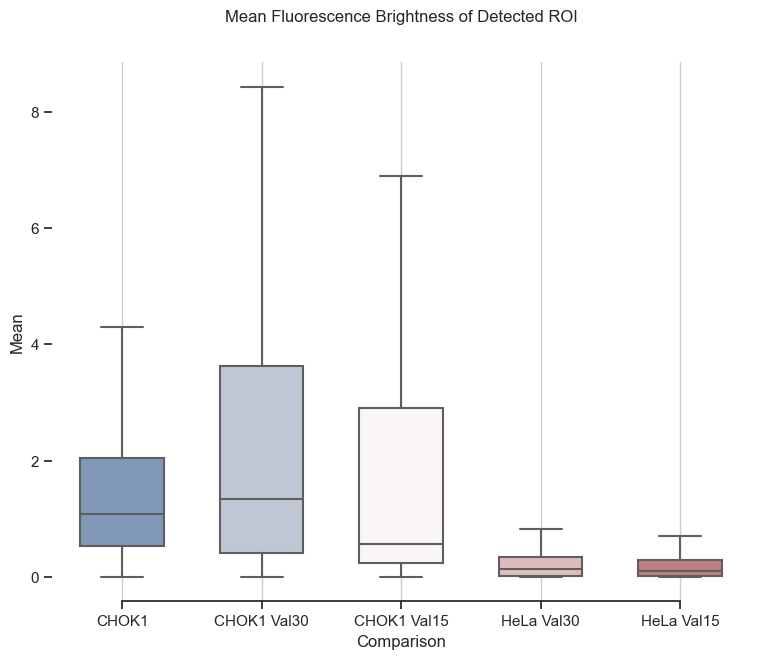

In [23]:
sns.set_theme(style="ticks")

# Initialize the figure
f, ax = plt.subplots(figsize=(9, 7))

# Plot
sns.boxplot(
    x="Set_name",
    y="Mean",
    data=all_df,
    width=0.6,
    palette="vlag",
    showfliers=False,
)


# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="Mean")
ax.set(xlabel="Comparison")
sns.despine(trim=True, left=True)
plt.title("Mean Fluorescence Brightness of Detected ROI", y=1.06)

plt.savefig("./" + vis_name + "_boxplot.png", bbox_inches="tight")
plt.show()

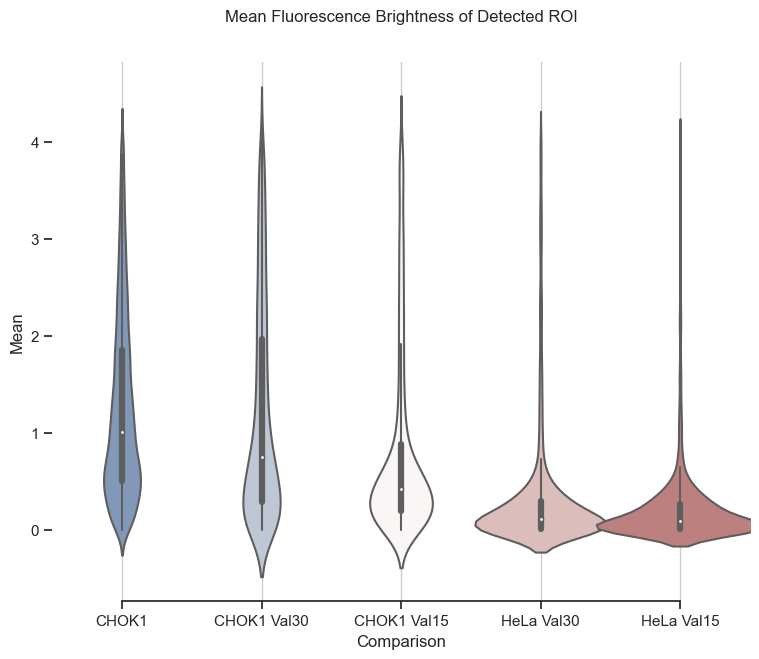

In [24]:
Q1 = all_df.Mean.quantile(0.25)
Q3 = all_df.Mean.quantile(0.75)
IQR = Q3 - Q1
cols = ["Mean"]
all_df = all_df[
    ~((all_df[cols] < (Q1 - 1.5 * IQR)) | (all_df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)
]

sns.set_theme(style="ticks")

# Initialize the figure
f, ax = plt.subplots(figsize=(9, 7))

# Plot
sns.violinplot(
    x="Set_name",
    y="Mean",
    data=all_df,
    width=1.2,
    palette="vlag",
    showfliers=False,
)


# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="Mean")
ax.set(xlabel="Comparison")
sns.despine(trim=True, left=True)
plt.title("Mean Fluorescence Brightness of Detected ROI", y=1.06)
plt.savefig("./" + vis_name + "_violinplot.png", bbox_inches="tight")
plt.show()

In [25]:
watermark(iversions=True, globals_=globals())
print(watermark())

Last updated: 2023-03-10T14:04:06.044020+01:00

Python implementation: CPython
Python version       : 3.9.16
IPython version      : 8.9.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 60 Stepping 3, GenuineIntel
CPU cores   : 8
Architecture: 64bit



In [26]:
print(
    watermark(
        packages="watermark,numpy,pandas,seaborn,scipy,statannotations,statsmodels"
    )
)

watermark      : 2.3.1
numpy          : 1.24.1
pandas         : 1.5.3
seaborn        : 0.11.2
scipy          : 1.10.0
statannotations: 0.5.0
statsmodels    : 0.13.5

